# import 

In [30]:
import toml
import json
import time
import torch
import pickle
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Module,Identity,Sequential
from typing import Dict,Tuple
from ecode.m6Anet.blocks import PoolingFilter
from sklearn.metrics import roc_auc_score

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DataLoader

In [3]:
class FlattenedDataset(data.Dataset):
    def __init__(self,original_dataset):
        self.flattened_data=[]
        for data in original_dataset:
            self.flattened_data.extend(data)
    def __len__(self):
        return len(self.flattened_data)
    def __getitem__(self,index):
        if isinstance(index,(list,np.ndarray)):
            return [self.flattened_data[i] for i in index]
        else:
            return self.flattened_data[index]

In [25]:
class m6AnetDataset(data.Dataset):
    def __init__(self,path,use_file):
        self.k5_center=[11,12,13]
        self.k5_pos=[]
        for center in self.k5_center:
            self.k5_pos.append([center-2,center+3])
        print('using',len(self.k5_center),'sites')

        samples_dic={}
        k5_list=[]
        with open(path+'/'+use_file+'.txt','r') as f:
            for line in f.readlines():
                f_name,label=line.strip().split()
                with open(path+'/'+f_name+'.index') as f2:
                    for line2 in f2.readlines():
                        sample,start,end=line2.strip().split('\t')
                        if sample not in samples_dic:
                            samples_dic[sample]=[]
                        samples_dic[sample].append((f_name,int(start),int(end),int(label)))
                        with open(path+'/'+f_name+'.json') as f:
                            f.seek(int(start),0)
                            json_str=f.read(int(end)-int(start))
                            Ls=json_str.strip().split('\n')
                            k_str=json.loads(Ls[0])
                            for k5_start,k5_end in self.k5_pos:
                                k5=k_str[k5_start:k5_end]
                                if k5 not in k5_list:
                                    k5_list.append(k5)
        print('total',len(k5_list),' possible k5 as:')
        print(k5_list)
        self.k5_list=np.array(k5_list)
        
        self.path=path
        self.samples_keys=list(samples_dic.keys())
        self.samples_dic=samples_dic

    def __getitem__(self,index):
        R_dicts=[]
        for single_sample in self.samples_dic[self.samples_keys[index]]:
            file,seek_start,seek_end,label=single_sample
            R_dict={'X':[],'kmer':[],'label':label}
            with open(self.path+'/'+file+'.json') as f:
                f.seek(seek_start,0)
                json_str=f.read(seek_end-seek_start)
                Ls=json_str.strip().split('\n')
                k_str=json.loads(Ls[0])
                for k5_start,k5_end in self.k5_pos:
                    k5=k_str[k5_start:k5_end]
                    R_dict['kmer'].append(np.where(self.k5_list==k5)[0][0])
                for L in Ls[1:]:
                    L_data=json.loads(L)
                    t_feature=[]
                    for center in self.k5_center:
                        each=L_data[center]
                        if each[0]<0:
                            t_feature.extend([0,0,0])
                        else:
                            t_feature.extend(each)
                    R_dict['X'].append(t_feature)
            for key in R_dict:
                R_dict[key]=torch.tensor(R_dict[key])
            R_dict['kmer']=R_dict['kmer'].repeat(len(R_dict['X']),1)
            R_dicts.append(R_dict)
        return R_dicts                
    def __len__(self):
        return len(self.samples_dic)

In [26]:
dataset=m6AnetDataset('./edata/DataSet/m6A','use_files')
print(len(dataset))
K5_TYPES=len(dataset.k5_list)

using 3 sites
total 66  possible k5 as:
['TAAAC', 'AAACT', 'AACTG', 'AGAAC', 'GAACA', 'AACAT', 'TGAAC', 'GGGAC', 'GGACT', 'GACTG', 'CAGAC', 'AGACC', 'GACCT', 'CGGAC', 'GGACA', 'GACAG', 'AGGAC', 'GACTT', 'TAGAC', 'AGACT', 'GAACC', 'AACCC', 'GAACT', 'AACTC', 'GGACC', 'GACCG', 'TGGAC', 'GACTA', 'GACTC', 'CTAAC', 'TAACT', 'AACTT', 'ATGAC', 'TGACC', 'GACCC', 'AACCG', 'CAAAC', 'GAGAC', 'AAGAC', 'TGACT', 'AACAG', 'GGAAC', 'AACAA', 'GACAC', 'GACAT', 'TTGAC', 'GAAAC', 'AGACA', 'CGAAC', 'CTGAC', 'GACAA', 'AACCT', 'GACCA', 'GTGAC', 'AAAAC', 'AACTA', 'TGACA', 'ATAAC', 'TTAAC', 'AACAC', 'AACCA', 'AAACA', 'GTAAC', 'AAACC', 'TAACC', 'TAACA']
3836


In [27]:
RELOAD=0
if RELOAD==1:
    dataset=m6AnetDataset('./edata/DataSet/m6A','use_files')
    train_size=int(len(dataset)*0.6)
    val_size=int(len(dataset)*0.2)
    test_size=len(dataset)-val_size-train_size
    train_set,val_set,test_set=torch.utils.data.random_split(dataset,[train_size,val_size,test_size])
    flattened_train_set=FlattenedDataset(train_set)
    flattened_val_set=FlattenedDataset(val_set)
    flattened_test_set=FlattenedDataset(test_set)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_val_set)',len(flattened_val_set))
    print('len(flattened_test_set)',len(flattened_test_set))

    with open('./edata/Save_DataSet/m6A_m6Anet_train_set.pkl','wb') as f:
        pickle.dump(flattened_train_set,f)
    with open('./edata/Save_DataSet/m6A_m6Anet_val_set.pkl','wb') as f:
        pickle.dump(flattened_val_set,f)
    with open('./edata/Save_DataSet/m6A_m6Anet_test_set.pkl','wb') as f:
        pickle.dump(flattened_test_set,f)
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    val_loader=DataLoader(flattened_val_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)
else:
    with open('./edata/Save_DataSet/m6A_m6Anet_train_set.pkl','rb') as f:
        flattened_train_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_m6Anet_val_set.pkl','rb') as f:
        flattened_val_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_m6Anet_test_set.pkl','rb') as f:
        flattened_test_set=pickle.load(f)
    print('len(flattened_train_set)',len(flattened_train_set))
    print('len(flattened_val_set)',len(flattened_val_set))
    print('len(flattened_test_set)',len(flattened_test_set))
    
    train_loader=DataLoader(flattened_train_set,batch_size=5,shuffle=True)
    val_loader=DataLoader(flattened_val_set,batch_size=5,shuffle=True)
    test_loader=DataLoader(flattened_test_set,batch_size=5,shuffle=True)

len(flattened_train_set) 3846
len(flattened_val_set) 1264
len(flattened_test_set) 1269


# model

In [9]:
class MILModel(Module):
    def __init__(self,model_config):
        super(MILModel,self).__init__()
        self.model_config=model_config
        self.read_level_encoder=None
        self.pooling_filter=None
        self.decoder=None
        self.build_model()

    def build_model(self):
        blocks=self.model_config['block']
        seq_model=[]
        for block in blocks:
            block_type=block.pop('block_type')
            block_obj=self._build_block(block_type,**block)

            if isinstance(block_obj,PoolingFilter):
                if len(seq_model)>0:
                    self.read_level_encoder=Sequential(*seq_model)
                else:
                    self.read_level_encoder=None

                self.pooling_filter=block_obj
                seq_model=[]
            else:
                seq_model.append(block_obj)

        if (self.read_level_encoder is None) and (self.pooling_filter is None):
            self.read_level_encoder=Sequential(*seq_model)
            self.pooling_filter=Identity()
            self.decoder=Identity()
        else:
            if len(seq_model)==0:
                self.decoder=Identity()
            else:
                self.decoder=Sequential(*seq_model)

    def _build_block(self,block_type,**kwargs):
        from ecode.m6Anet import blocks
        block_obj=getattr(blocks,block_type)
        return block_obj(**kwargs)

    def get_read_representation(self,x):
        if self.read_level_encoder is None:
            return x
        else:
            return self.read_level_encoder(x)

    def get_read_probability(self,x):
        read_representation=self.get_read_representation(x)
        return self.pooling_filter.predict_read_level_prob(read_representation)

    def get_site_representation(self,x):
        return self.pooling_filter(self.get_read_representation(x))

    def get_site_probability(self,x):
        return self.decoder(self.get_site_representation(x))

    def get_read_site_probability(self,x):
        read_representation=self.get_read_representation(x)
        read_level_probability=self.pooling_filter.predict_read_level_prob(read_representation)
        site_level_probability=self.decoder(self.pooling_filter(read_representation))
        return read_level_probability,site_level_probability,read_representation

    def get_attention_weights(self,x):
        if hasattr(self.pooling_filter, "get_attention_weights"):
            return self.pooling_filter.get_attention_weights(self.get_read_representation(x))
        else:
            raise ValueError("Pooling filter does not have attention weights")

    def forward(self,x):
        if type(x) is np.ndarray:
            probs=torch.tensor([]).to(x[0]['X'].device)
            for sub_x in x:
                sub_x={k:v.unsqueeze(0) for k,v in sub_x.items()}
                prob=self.get_site_probability(sub_x).unsqueeze(0)
                probs=torch.cat((probs,prob.unsqueeze(0)),dim=0)
        else:
            probs=self.get_site_probability(x)
        return probs

# For Train and Test

In [10]:
def test(model,test_loader,device,read_reduce=0):
    model.eval()
    right_count,all_count=0,0
    prob_all,Y_all=[],[]
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
    roauc=roc_auc_score(Y_all,prob_all)

    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(roauc,accuracy))
    torch.cuda.empty_cache()

def train(model,train_loader,val_loader,device,optimizer,loss_func,epochs,read_reduce=0):
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        total_loss=0
        model.train()
        for _,l_dic in enumerate(train_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label']
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            loss=loss_func(pre_y,data_y.float())
            total_loss+=loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('epoch {}, loss:{:.4f}'.format(epoch+1,total_loss.item()/len(train_loader)))
        if epoch%10==9:
            print('At epoch '+str(epoch+1),':')
            test(model,val_loader,device,read_reduce)
            torch.save(model.state_dict(),'./model/model_'+str(epoch+1)+'_'+str(int(time.time()))+'.pkl')

In [11]:
def detailed_test(model,test_loader,device,read_reduce=0,curve_name=None):
    model.eval()
    right_count,all_count=0,0
    more_dict={0.5:[0,0],0.6:[0,0],0.8:[0,0],0.7:[0,0],0.9:[0,0],0.95:[0,0],0.98:[0,0],\
               0.99:[0,0],0.995:[0,0],0.999:[0,0],0.9995:[0,0],0.9999:[0,0],0.99995:[0,0],\
               0.99999:[0,0],0.999995:[0,0],0.999999:[0,0]}
    prob_all,Y_all=[],[]
    motif_found_dict={}
    motif_dict={}
    with torch.no_grad():
        for _,l_dic in enumerate(test_loader):
            l_dic={k:v.to(device) for k, v in l_dic.items()}
            data_y=l_dic['label'].to(torch.int64)
            l_dic['X']=l_dic['X'][:,read_reduce:]
            l_dic['kmer']=l_dic['kmer'][:,read_reduce:]
            pre_y=model(l_dic)
            out_y=pre_y>0.5
            right_count+=out_y.eq(data_y).sum()
            all_count+=len(data_y)
            for each in pre_y:
                prob_all.append(np.array(each.cpu()))
            for each in data_y:
                Y_all.append(np.array(each.cpu()))
            for key in more_dict:
                more_dict[key][0]+=((pre_y>key)&data_y).sum()
                more_dict[key][1]+=(pre_y>key).sum()
    if curve_name:
        save_frame=pd.DataFrame({'label':Y_all,'pred':prob_all})
        save_frame.to_csv('./edata/Save_for_drawing/'+curve_name+'_curve.csv',index=False,sep=',')

    print('Im total',all_count,'samples:')
    auc=roc_auc_score(Y_all,prob_all)
    accuracy=100*(right_count/all_count).item()
    print('AUC:{:.4f}   accuracy:{:.4f}%'.format(auc,accuracy))
    for key in more_dict:
        if more_dict[key][1]>0:
            print('Precision when positive threshold at {:g} is :{:.4f}% (total:{:d})'.format(key,more_dict[key][0]/more_dict[key][1],more_dict[key][1]))
    torch.cuda.empty_cache()

# Train

In [12]:
config_file_20reads='./ecode/m6Anet/m6Anet_3sites_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
model=MILModel(model_config_20reads).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=200
train(model,train_loader,val_loader,device,optimizer,loss_func,epochs,read_reduce=30)

epoch 1, loss:0.7139
epoch 2, loss:0.6431
epoch 3, loss:0.6275
epoch 4, loss:0.6159
epoch 5, loss:0.6077
epoch 6, loss:0.6019
epoch 7, loss:0.5898
epoch 8, loss:0.5814
epoch 9, loss:0.5686
epoch 10, loss:0.5594
At epoch 10 :
AUC:0.7495   accuracy:68.9873%
epoch 11, loss:0.5544
epoch 12, loss:0.5491
epoch 13, loss:0.5362
epoch 14, loss:0.5419
epoch 15, loss:0.5346
epoch 16, loss:0.5337
epoch 17, loss:0.5366
epoch 18, loss:0.5263
epoch 19, loss:0.5352
epoch 20, loss:0.5240
At epoch 20 :
AUC:0.7910   accuracy:73.7342%
epoch 21, loss:0.5169
epoch 22, loss:0.5186
epoch 23, loss:0.5234
epoch 24, loss:0.5155
epoch 25, loss:0.5150
epoch 26, loss:0.5151
epoch 27, loss:0.5248
epoch 28, loss:0.5131
epoch 29, loss:0.5118
epoch 30, loss:0.5147
At epoch 30 :
AUC:0.8064   accuracy:73.7342%
epoch 31, loss:0.5151
epoch 32, loss:0.5071
epoch 33, loss:0.5116
epoch 34, loss:0.5002
epoch 35, loss:0.5090
epoch 36, loss:0.5090
epoch 37, loss:0.5066
epoch 38, loss:0.5034
epoch 39, loss:0.5022
epoch 40, loss:0

In [13]:
config_file_50reads='./ecode/m6Anet/m6Anet_3sites_50reads.toml'
model_config_50reads=toml.load(config_file_50reads)
model_config_50reads['block'][0]['input_channel']=K5_TYPES
model=MILModel(model_config_50reads).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=200
train(model,train_loader,val_loader,device,optimizer,loss_func,epochs)

epoch 1, loss:4.0127
epoch 2, loss:2.7723
epoch 3, loss:2.3850
epoch 4, loss:1.5015
epoch 5, loss:0.6793
epoch 6, loss:0.6705
epoch 7, loss:0.6601
epoch 8, loss:0.6568
epoch 9, loss:0.6458
epoch 10, loss:0.6430
At epoch 10 :
AUC:0.6552   accuracy:58.7025%
epoch 11, loss:0.6351
epoch 12, loss:0.6265
epoch 13, loss:0.6186
epoch 14, loss:0.6067
epoch 15, loss:0.5964
epoch 16, loss:0.5945
epoch 17, loss:0.5856
epoch 18, loss:0.5818
epoch 19, loss:0.5776
epoch 20, loss:0.5723
At epoch 20 :
AUC:0.7206   accuracy:63.3703%
epoch 21, loss:0.5685
epoch 22, loss:0.5658
epoch 23, loss:0.5653
epoch 24, loss:0.5615
epoch 25, loss:0.5583
epoch 26, loss:0.5602
epoch 27, loss:0.5569
epoch 28, loss:0.5489
epoch 29, loss:0.5480
epoch 30, loss:0.5496
At epoch 30 :
AUC:0.7316   accuracy:65.5854%
epoch 31, loss:0.5413
epoch 32, loss:0.5445
epoch 33, loss:0.5370
epoch 34, loss:0.5375
epoch 35, loss:0.5355
epoch 36, loss:0.5364
epoch 37, loss:0.5294
epoch 38, loss:0.5282
epoch 39, loss:0.5261
epoch 40, loss:0

# Test

In [15]:
config_file_20reads='./ecode/m6Anet/m6Anet_3sites_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
model=MILModel(model_config_20reads).to(device)
model.load_state_dict(torch.load('./model/m6Anet_120_20reads_3sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,read_reduce=30,curve_name='m6Anet,20reads_3sites')

Im total 1269 samples:
AUC:0.8222   accuracy:75.9653%
Precision when positive threshold at 0.5 is :0.7565% (total:727)
Precision when positive threshold at 0.6 is :0.7877% (total:636)
Precision when positive threshold at 0.8 is :0.8449% (total:432)
Precision when positive threshold at 0.7 is :0.8245% (total:530)
Precision when positive threshold at 0.9 is :0.8785% (total:288)
Precision when positive threshold at 0.95 is :0.9128% (total:195)
Precision when positive threshold at 0.98 is :0.9298% (total:114)
Precision when positive threshold at 0.99 is :0.9487% (total:78)
Precision when positive threshold at 0.995 is :0.9434% (total:53)
Precision when positive threshold at 0.999 is :1.0000% (total:25)
Precision when positive threshold at 0.9995 is :1.0000% (total:18)
Precision when positive threshold at 0.9999 is :1.0000% (total:9)
Precision when positive threshold at 0.99995 is :1.0000% (total:8)
Precision when positive threshold at 0.99999 is :1.0000% (total:5)
Precision when positive t

In [14]:
config_file_50reads='./ecode/m6Anet/m6Anet_3sites_50reads.toml'
model_config_50reads=toml.load(config_file_50reads)
model_config_50reads['block'][0]['input_channel']=K5_TYPES
model=MILModel(model_config_50reads).to(device)
model.load_state_dict(torch.load('./model/m6Anet_140_50reads_3sites.pkl',weights_only=True))
detailed_test(model,test_loader,device,read_reduce=0,curve_name='m6Anet,50reads_3sites')

Im total 1269 samples:
AUC:0.7797   accuracy:72.2616%
Precision when positive threshold at 0.5 is :0.6993% (total:818)
Precision when positive threshold at 0.6 is :0.7308% (total:702)
Precision when positive threshold at 0.8 is :0.7798% (total:436)
Precision when positive threshold at 0.7 is :0.7556% (total:577)
Precision when positive threshold at 0.9 is :0.8154% (total:298)
Precision when positive threshold at 0.95 is :0.8311% (total:219)
Precision when positive threshold at 0.98 is :0.8296% (total:135)
Precision when positive threshold at 0.99 is :0.8230% (total:113)
Precision when positive threshold at 0.995 is :0.8706% (total:85)
Precision when positive threshold at 0.999 is :0.8367% (total:49)
Precision when positive threshold at 0.9995 is :0.8158% (total:38)
Precision when positive threshold at 0.9999 is :0.7778% (total:27)
Precision when positive threshold at 0.99995 is :0.8333% (total:24)
Precision when positive threshold at 0.99999 is :0.8750% (total:16)
Precision when positi

# 5 sites

In [23]:
class _5sites_m6AnetDataset(data.Dataset):
    def __init__(self,path,use_file):
        self.k5_center=[10,11,12,13,14]
        self.k5_pos=[]
        for center in self.k5_center:
            self.k5_pos.append([center-2,center+3])
        print('using',len(self.k5_center),'sites')

        samples_dic={}
        k5_list=[]
        with open(path+'/'+use_file+'.txt','r') as f:
            for line in f.readlines():
                f_name,label=line.strip().split()
                with open(path+'/'+f_name+'.index') as f2:
                    for line2 in f2.readlines():
                        sample,start,end=line2.strip().split('\t')
                        if sample not in samples_dic:
                            samples_dic[sample]=[]
                        samples_dic[sample].append((f_name,int(start),int(end),int(label)))
                        with open(path+'/'+f_name+'.json') as f:
                            f.seek(int(start),0)
                            json_str=f.read(int(end)-int(start))
                            Ls=json_str.strip().split('\n')
                            k_str=json.loads(Ls[0])
                            for k5_start,k5_end in self.k5_pos:
                                k5=k_str[k5_start:k5_end]
                                if k5 not in k5_list:
                                    k5_list.append(k5)
        print('total',len(k5_list),' possible k5 as:')
        print(k5_list)
        self.k5_list=np.array(k5_list)
        
        self.path=path
        self.samples_keys=list(samples_dic.keys())
        self.samples_dic=samples_dic

    def __getitem__(self,index):
        R_dicts=[]
        for single_sample in self.samples_dic[self.samples_keys[index]]:
            file,seek_start,seek_end,label=single_sample
            R_dict={'X':[],'kmer':[],'label':label}
            with open(self.path+'/'+file+'.json') as f:
                f.seek(seek_start,0)
                json_str=f.read(seek_end-seek_start)
                Ls=json_str.strip().split('\n')
                k_str=json.loads(Ls[0])
                for k5_start,k5_end in self.k5_pos:
                    k5=k_str[k5_start:k5_end]
                    R_dict['kmer'].append(np.where(self.k5_list==k5)[0][0])
                for L in Ls[1:]:
                    L_data=json.loads(L)
                    t_feature=[]
                    for center in self.k5_center:
                        each=L_data[center]
                        if each[0]<0:
                            t_feature.extend([0,0,0])
                        else:
                            t_feature.extend(each)
                    R_dict['X'].append(t_feature)
            for key in R_dict:
                R_dict[key]=torch.tensor(R_dict[key])
            R_dict['kmer']=R_dict['kmer'].repeat(len(R_dict['X']),1)
            R_dicts.append(R_dict)
        return R_dicts                
    def __len__(self):
        return len(self.samples_dic)

In [24]:
_5sites_dataset=_5sites_m6AnetDataset('./edata/DataSet/m6A','use_files')
print(len(_5sites_dataset))
_5sites_K5_TYPES=len(_5sites_dataset.k5_list)

using 5 sites
total 206  possible k5 as:
['GTAAA', 'TAAAC', 'AAACT', 'AACTG', 'ACTGA', 'AAGAA', 'AGAAC', 'GAACA', 'AACAT', 'ACATT', 'ATGAA', 'TGAAC', 'ACATG', 'TGGGA', 'GGGAC', 'GGACT', 'GACTG', 'ACTGC', 'ACAGA', 'CAGAC', 'AGACC', 'GACCT', 'ACCTA', 'CCGGA', 'CGGAC', 'GGACA', 'GACAG', 'ACAGG', 'GAGGA', 'AGGAC', 'GACTT', 'ACTTG', 'ATAGA', 'TAGAC', 'AGACT', 'GAACC', 'AACCC', 'ACCCA', 'CAGAA', 'GAACT', 'AACTC', 'ACTCA', 'AAGGA', 'GGACC', 'GACCG', 'ACCGT', 'GTGGA', 'TGGAC', 'GACTA', 'ACTAA', 'CAGGA', 'GACTC', 'ACTCT', 'ACTCG', 'ACGGA', 'ACTTC', 'CTAAC', 'TAACT', 'AACTT', 'ACTTT', 'AATGA', 'ATGAC', 'TGACC', 'GACCC', 'ACCCC', 'GAGAA', 'AACCG', 'CGGGA', 'ACCTG', 'ACCGC', 'ACCTC', 'CTGGA', 'ATGGA', 'GGGGA', 'AGGGA', 'ACAAA', 'CAAAC', 'ACTTA', 'AGAGA', 'GAGAC', 'GCAGA', 'ACTGG', 'CAAGA', 'AAGAC', 'TTGGA', 'ATAAA', 'TCAGA', 'ACCCG', 'GATGA', 'TGACT', 'TCGGA', 'TAGAA', 'AACAG', 'ACAGC', 'AGGAA', 'GGAAC', 'AACAA', 'ACAAT', 'TGGAA', 'GACAC', 'ACACA', 'GACAT', 'ACATC', 'ACAGT', 'TAGGA', 'ACATA', 'ACC

In [53]:
RELOAD=0
if RELOAD==1:
    _5sites_dataset=_5sites_m6AnetDataset('./edata/DataSet/m6A','use_files')
    train_size=int(len(_5sites_dataset)*0.6)
    val_size=int(len(_5sites_dataset)*0.2)
    test_size=len(_5sites_dataset)-val_size-train_size
    train_set,val_set,test_set=torch.utils.data.random_split(_5sites_dataset,[train_size,val_size,test_size])
    _5sites_flattened_train_set=FlattenedDataset(train_set)
    _5sites_flattened_val_set=FlattenedDataset(val_set)
    _5sites_flattened_test_set=FlattenedDataset(test_set)
    print('len(_5sites_flattened_train_set)',len(_5sites_flattened_train_set))
    print('len(_5sites_flattened_val_set)',len(_5sites_flattened_val_set))
    print('len(_5sites_flattened_test_set)',len(_5sites_flattened_test_set))

    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_train_set.pkl','wb') as f:
        pickle.dump(_5sites_flattened_train_set,f)
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_val_set.pkl','wb') as f:
        pickle.dump(_5sites_flattened_val_set,f)
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_test_set.pkl','wb') as f:
        pickle.dump(_5sites_flattened_test_set,f)
    _5sites_train_loader=DataLoader(_5sites_flattened_train_set,batch_size=5,shuffle=True)
    _5sites_val_loader=DataLoader(_5sites_flattened_val_set,batch_size=5,shuffle=True)
    _5sites_test_loader=DataLoader(_5sites_flattened_test_set,batch_size=5,shuffle=True)
else:
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_train_set.pkl','rb') as f:
        _5sites_flattened_train_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_val_set.pkl','rb') as f:
        _5sites_flattened_val_set=pickle.load(f)
    with open('./edata/Save_DataSet/m6A_m6Anet_5sites_test_set.pkl','rb') as f:
        _5sites_flattened_test_set=pickle.load(f)
    print('len(_5sites_flattened_train_set)',len(_5sites_flattened_train_set))
    print('len(_5sites_flattened_val_set)',len(_5sites_flattened_val_set))
    print('len(_5sites_flattened_test_set)',len(_5sites_flattened_test_set))
    
    _5sites_train_loader=DataLoader(_5sites_flattened_train_set,batch_size=5,shuffle=True)
    _5sites_val_loader=DataLoader(_5sites_flattened_val_set,batch_size=5,shuffle=True)
    _5sites_test_loader=DataLoader(_5sites_flattened_test_set,batch_size=5,shuffle=True)

len(_5sites_flattened_train_set) 3836
len(_5sites_flattened_val_set) 1246
len(_5sites_flattened_test_set) 1297


In [54]:
config_file_5sites_20reads='./ecode/m6Anet/m6Anet_5sites_20reads.toml'
model_config_5sites_20reads=toml.load(config_file_5sites_20reads)
model_config_5sites_20reads['block'][0]['input_channel']=_5sites_K5_TYPES
model=MILModel(model_config_5sites_20reads).to(device)
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_func=nn.BCELoss()
epochs=200
train(model,_5sites_train_loader,_5sites_val_loader,device,optimizer,loss_func,epochs,read_reduce=30)

epoch 1, loss:0.7154
epoch 2, loss:0.6404
epoch 3, loss:0.6241
epoch 4, loss:0.6105
epoch 5, loss:0.5990
epoch 6, loss:0.5915
epoch 7, loss:0.5828
epoch 8, loss:0.5742
epoch 9, loss:0.5660
epoch 10, loss:0.5676
At epoch 10 :
AUC:0.7184   accuracy:66.4526%
epoch 11, loss:0.5584
epoch 12, loss:0.5480
epoch 13, loss:0.5484
epoch 14, loss:0.5374
epoch 15, loss:0.5419
epoch 16, loss:0.5339
epoch 17, loss:0.5357
epoch 18, loss:0.5262
epoch 19, loss:0.5275
epoch 20, loss:0.5213
At epoch 20 :
AUC:0.7458   accuracy:68.1380%
epoch 21, loss:0.5164
epoch 22, loss:0.5110
epoch 23, loss:0.5056
epoch 24, loss:0.5016
epoch 25, loss:0.5030
epoch 26, loss:0.5088
epoch 27, loss:0.5030
epoch 28, loss:0.4978
epoch 29, loss:0.4976
epoch 30, loss:0.4915
At epoch 30 :
AUC:0.7674   accuracy:65.5698%
epoch 31, loss:0.4869
epoch 32, loss:0.4962
epoch 33, loss:0.4798
epoch 34, loss:0.4824
epoch 35, loss:0.4845
epoch 36, loss:0.4876
epoch 37, loss:0.4789
epoch 38, loss:0.4744
epoch 39, loss:0.4726
epoch 40, loss:0

In [55]:
config_file_5sites_20reads='./ecode/m6Anet/m6Anet_5sites_20reads.toml'
model_config_5sites_20reads=toml.load(config_file_5sites_20reads)
model_config_5sites_20reads['block'][0]['input_channel']=_5sites_K5_TYPES
model=MILModel(model_config_5sites_20reads).to(device)
model.load_state_dict(torch.load('./model/m6Anet_30_20reads_5sites.pkl',weights_only=True))
detailed_test(model,_5sites_test_loader,device,read_reduce=30,curve_name='m6Anet,20reads_5sites')

Im total 1297 samples:
AUC:0.7798   accuracy:67.6947%
Precision when positive threshold at 0.5 is :0.6530% (total:997)
Precision when positive threshold at 0.6 is :0.6943% (total:870)
Precision when positive threshold at 0.8 is :0.8074% (total:540)
Precision when positive threshold at 0.7 is :0.7366% (total:729)
Precision when positive threshold at 0.9 is :0.8576% (total:288)
Precision when positive threshold at 0.95 is :0.8875% (total:160)
Precision when positive threshold at 0.98 is :0.9351% (total:77)
Precision when positive threshold at 0.99 is :0.9500% (total:40)
Precision when positive threshold at 0.995 is :1.0000% (total:21)
Precision when positive threshold at 0.999 is :1.0000% (total:8)
Precision when positive threshold at 0.9995 is :1.0000% (total:3)


# Shap explain import

In [57]:
import shap
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import RobustScaler,MinMaxScaler

import ecode.explainer.m6AnetExp
import importlib
importlib.reload(ecode.explainer.m6AnetExp)
from ecode.explainer.m6AnetExp import m6Anet_DeepEXP

shap.initjs()
np.set_printoptions(precision=6)

In [58]:
def gini_coefficient(x_array):
    x=torch.tensor(x_array.copy())
    sorted_x,_=torch.sort(x)
    n=x.size(0)
    
    cum_x=torch.cumsum(sorted_x, dim=0)

    gini_numerator=(2*torch.arange(1,n+1,dtype=x.dtype,device=x.device)*sorted_x).sum()
    gini_denominator=n*cum_x[-1]

    gini_coefficient=(gini_numerator/gini_denominator)-(n+1)/n
    return gini_coefficient

In [13]:
print(len(flattened_train_set),len(flattened_test_set))

5087 1292


# Shap explain 20reads

In [66]:
read_reduce=30

background_set_20reads=[]
sample_set_20reads=[]

background_set_size=1000
sample_set_size=400
#shuffled_flattened_train_set=flattened_train_set[random.sample(range(len(flattened_train_set)),background_set_size)]
#shuffled_flattened_test_set=flattened_test_set[random.sample(range(len(flattened_test_set)),sample_set_size)]

#not shuffle for reproductivity 
shuffled_flattened_train_set=flattened_train_set[:background_set_size]
shuffled_flattened_test_set=flattened_test_set[:sample_set_size]


for i in range(background_set_size):
    ap_dic=shuffled_flattened_train_set[i].copy()
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    background_set_20reads.append(ap_dic)

#only positive samples are selected for sample set
for i in range(sample_set_size):
    ap_dic=shuffled_flattened_test_set[i].copy()
    if ap_dic['label']==0:
        continue
    for k,v in ap_dic.items():
        if k=='X' or k=='kmer':
            v=v[read_reduce:]
        v=v.to(device)
        ap_dic[k]=v
    sample_set_20reads.append(ap_dic)
background_set_20reads=np.array(background_set_20reads)
sample_set_20reads=np.array(sample_set_20reads)

In [68]:
config_file_20reads='./ecode/m6Anet/m6Anet_3sites_20reads.toml'
model_config_20reads=toml.load(config_file_20reads)
model_config_20reads['block'][0]['input_channel']=K5_TYPES
model_20reads=MILModel(model_config_20reads).to(device)
model_20reads.load_state_dict(torch.load('./model/m6Anet_120_20reads_3sites.pkl',weights_only=True))

<All keys matched successfully>

In [69]:
explainer_20reads=m6Anet_DeepEXP(model_20reads,background_set_20reads)
shap_values_20reads=explainer_20reads.shap_values(sample_set_20reads)
shap_values_20reads=np.array(shap_values_20reads[0])
shap_values_20reads=shap_values_20reads.reshape(shap_values_20reads.shape[:-1])

[6.458229e-01 1.634271e-01 7.027593e-02 3.903660e-02 2.424512e-02
 1.591994e-02 1.099645e-02 7.191941e-03 5.656430e-03 4.310163e-03
 3.201506e-03 2.501057e-03 2.008579e-03 1.619348e-03 1.282502e-03
 1.045938e-03 8.546919e-04 4.865080e-04 1.119976e-04 5.376965e-06]


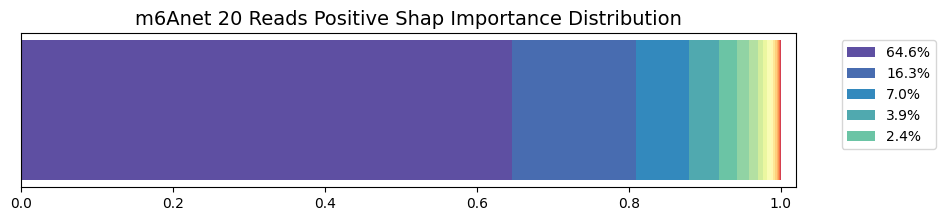

positive shap gini for 20reads positive samples is: 0.853958


In [70]:
shap_use=shap_values_20reads.copy()
shap_use[shap_values_20reads<0]=0
row_sums=shap_use.sum(axis=1,keepdims=True)
row_sums[row_sums==0]=1
normalized_shap_use=shap_use/row_sums
sorted_normalized_shap_use=np.sort(normalized_shap_use,axis=1)[:,::-1]

#importance distribution by the top N most important read by positive shap
importance_20reads=sorted_normalized_shap_use.sum(axis=0,keepdims=False)/normalized_shap_use.sum()
print(importance_20reads)

cmap=plt.colormaps.get_cmap('Spectral')
colors=cmap(np.linspace(1,0,len(importance_20reads)))
fig,ax=plt.subplots(figsize=(10,2))

left=0
for i,(imp,color) in enumerate(zip(importance_20reads,colors)):
    if i<5:
        label_use=f'{imp*100:.1f}%'
    else:
        label_use=None
    ax.barh(0,width=imp,left=left,height=0.5,color=color,label=label_use)
    left+=imp
ax.set_yticks([])
ax.set_xlim([0,1.02])
ax.set_title('m6Anet 20 Reads Positive Shap Importance Distribution',fontsize=14)
ax.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('./edata/Save_drawing/m6Anet_positive_shap_distribution_20reads.pdf',bbox_inches='tight')
plt.show()

gini_20reads=gini_coefficient(importance_20reads)
print('positive shap gini for 20reads positive samples is:',gini_20reads.cpu().numpy())